In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
#from tf.keras.models.Sequential import Sequential

In [ ]:
# https://www.tensorflow.org/tutorials/load_data/images 
# https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/

In [2]:
print(tf.__version__)
from google.colab import drive
drive.mount('/content/drive') 

2.8.2
Mounted at /content/drive


In [3]:
data_dir = '/content/drive/My Drive/Safa_Project/nasi'
import os
if os.path.exists(data_dir):
  print ('Folder Exists')

Folder Exists


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 13s 71ms/step - loss: 4.3983 - accuracy: 0.6023 - val_loss: 0.7674 - val_accuracy: 0.7076
Epoch 2/30
100/100 [==============================] - 4s 39ms/step - loss: 0.6740 - accuracy: 0.7553 - val_loss: 0.6820 - val_accuracy: 0.7653
Epoch 3/30
100/100 [==============================] - 4s 39ms/step - loss: 0.6730 - accuracy: 0.7641 - val_loss: 0.8327 - val_accuracy: 0.6643
Epoch 4/30
100/100 [==============================] - 4s 39ms/step - loss: 0.6235 - accuracy: 0.7829 - val_loss: 0.5419 - val_accuracy: 0.8087
Epoch 5/30
100/100 [==============================] - 4s 39ms/step - loss: 0.5691 - accuracy: 0.8018 - val_loss: 0.6147 - val_accuracy: 0.7942
Epoch 6/30
100/100 [==============================] - 4s 39ms/step - loss: 0.4949 - accuracy: 0.8381 - val_loss: 0.6018 - val_accuracy: 0.7726
Epoch 7/30
100/100 [==============================] - 4s 40ms/step - loss: 0.4194 - accuracy: 0.8394 - val_loss: 0.6754 - val_accuracy: 0.7798
Epoch 8/3

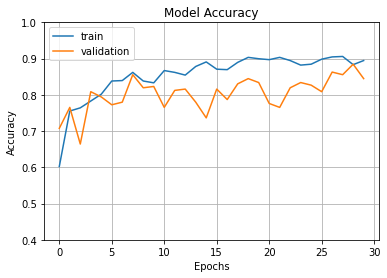

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 30
batch_size      : 8
learning rate   : 0.01


The Best Training   Acc 0.9058971405029297
The Best Validation Acc 0.8844765424728394
Evaluate on test data.....................
33/33 [==============================] - 3s 31ms/step - loss: 0.5342 - accuracy: 0.8333
Test loss, Test acc: [0.5341820120811462, 0.8333333134651184]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 30
batch_size = 8
effective_lr = 0.01
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 13s 72ms/step - loss: 1.2006 - accuracy: 0.6336 - val_loss: 0.8104 - val_accuracy: 0.7076
Epoch 2/30
100/100 [==============================] - 4s 39ms/step - loss: 0.5651 - accuracy: 0.7905 - val_loss: 0.5045 - val_accuracy: 0.8303
Epoch 3/30
100/100 [==============================] - 4s 39ms/step - loss: 0.4197 - accuracy: 0.8645 - val_loss: 0.4131 - val_accuracy: 0.8628
Epoch 4/30
100/100 [==============================] - 4s 39ms/step - loss: 0.4272 - accuracy: 0.8494 - val_loss: 0.3448 - val_accuracy: 0.8664
Epoch 5/30
100/100 [==============================] - 4s 38ms/step - loss: 0.3808 - accuracy: 0.8632 - val_loss: 0.3837 - val_accuracy: 0.8484
Epoch 6/30
100/100 [==============================] - 4s 38ms/step - loss: 0.3688 - accuracy: 0.8745 - val_loss: 0.3887 - val_accuracy: 0.8484
Epoch 7/30
100/100 [==============================] - 4s 38ms/step - loss: 0.3402 - accuracy: 0.8758 - val_loss: 0.4921 - val_accuracy: 0.8448
Epoch 8/3

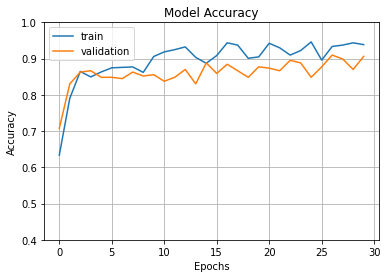

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 30
batch_size      : 8
learning rate   : 0.001


The Best Training   Acc 0.9460476636886597
The Best Validation Acc 0.909747302532196
Evaluate on test data.....................
33/33 [==============================] - 3s 33ms/step - loss: 0.3669 - accuracy: 0.8788
Test loss, Test acc: [0.36688387393951416, 0.8787878751754761]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 30
batch_size = 8
effective_lr = 0.001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 13s 71ms/step - loss: 1.0363 - accuracy: 0.6098 - val_loss: 0.8685 - val_accuracy: 0.7040
Epoch 2/30
100/100 [==============================] - 4s 39ms/step - loss: 0.6561 - accuracy: 0.7804 - val_loss: 0.7394 - val_accuracy: 0.7256
Epoch 3/30
100/100 [==============================] - 4s 39ms/step - loss: 0.5284 - accuracy: 0.8105 - val_loss: 0.5856 - val_accuracy: 0.7762
Epoch 4/30
100/100 [==============================] - 4s 42ms/step - loss: 0.4495 - accuracy: 0.8494 - val_loss: 0.5122 - val_accuracy: 0.8231
Epoch 5/30
100/100 [==============================] - 4s 39ms/step - loss: 0.3891 - accuracy: 0.8720 - val_loss: 0.4460 - val_accuracy: 0.8556
Epoch 6/30
100/100 [==============================] - 4s 40ms/step - loss: 0.3479 - accuracy: 0.8846 - val_loss: 0.4597 - val_accuracy: 0.8375
Epoch 7/30
100/100 [==============================] - 4s 42ms/step - loss: 0.3447 - accuracy: 0.8858 - val_loss: 0.4458 - val_accuracy: 0.8339
Epoch 8/3

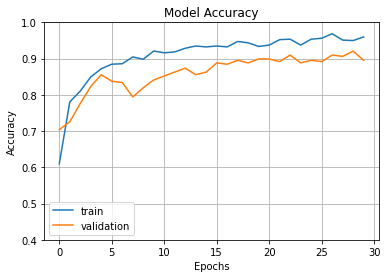

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 30
batch_size      : 8
learning rate   : 0.0001


The Best Training   Acc 0.9686324000358582
The Best Validation Acc 0.9205776453018188
Evaluate on test data.....................
33/33 [==============================] - 3s 33ms/step - loss: 0.2669 - accuracy: 0.9205
Test loss, Test acc: [0.2668503224849701, 0.9204545617103577]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 30
batch_size = 8
effective_lr = 0.0001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 13s 70ms/step - loss: 1.4666 - accuracy: 0.4228 - val_loss: 1.3871 - val_accuracy: 0.4440
Epoch 2/30
100/100 [==============================] - 4s 38ms/step - loss: 1.1978 - accuracy: 0.5395 - val_loss: 1.1878 - val_accuracy: 0.5415
Epoch 3/30
100/100 [==============================] - 4s 38ms/step - loss: 1.0449 - accuracy: 0.6361 - val_loss: 1.0541 - val_accuracy: 0.6209
Epoch 4/30
100/100 [==============================] - 4s 39ms/step - loss: 0.9488 - accuracy: 0.6775 - val_loss: 0.9757 - val_accuracy: 0.6643
Epoch 5/30
100/100 [==============================] - 4s 39ms/step - loss: 0.8482 - accuracy: 0.7202 - val_loss: 0.8963 - val_accuracy: 0.6859
Epoch 6/30
100/100 [==============================] - 4s 39ms/step - loss: 0.7729 - accuracy: 0.7277 - val_loss: 0.8374 - val_accuracy: 0.7040
Epoch 7/30
100/100 [==============================] - 4s 39ms/step - loss: 0.7353 - accuracy: 0.7440 - val_loss: 0.8012 - val_accuracy: 0.7112
Epoch 8/3

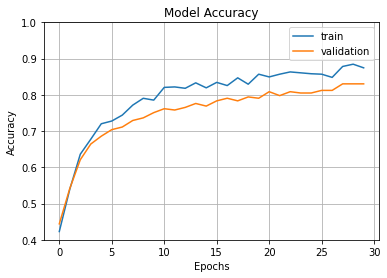

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 30
batch_size      : 8
learning rate   : 1e-05


The Best Training   Acc 0.884567141532898
The Best Validation Acc 0.8303248882293701
Evaluate on test data.....................
33/33 [==============================] - 3s 35ms/step - loss: 0.4333 - accuracy: 0.8447
Test loss, Test acc: [0.4332796633243561, 0.8446969985961914]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 30
batch_size = 8
effective_lr = 0.00001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


100/100 [==============================] - 13s 70ms/step - loss: 1.9010 - accuracy: 0.2288 - val_loss: 1.6962 - val_accuracy: 0.3177
Epoch 2/30
100/100 [==============================] - 4s 38ms/step - loss: 1.5590 - accuracy: 0.3750 - val_loss: 1.5561 - val_accuracy: 0.3827
Epoch 3/30
100/100 [==============================] - 4s 38ms/step - loss: 1.4500 - accuracy: 0.4275 - val_loss: 1.4756 - val_accuracy: 0.4152
Epoch 4/30
100/100 [==============================] - 4s 38ms/step - loss: 1.3655 - accuracy: 0.4650 - val_loss: 1.4089 - val_accuracy: 0.4332
Epoch 5/30
100/100 [==============================] - 4s 38ms/step - loss: 1.2997 - accuracy: 0.5025 - val_loss: 1.3538 - val_accuracy: 0.4801
Epoch 6/30
100/100 [==============================] - 4s 38ms/step - loss: 1.2596 - accuracy: 0.5325 - val_loss: 1.3060 - val_accuracy: 0.5126
Epoch 7/30
100/100 [==============================] - 4s 38ms/step - loss: 1.2216 - accuracy: 0.5487 - val_loss: 1.2671 - val_accuracy: 0.5199
Epoch 8/3

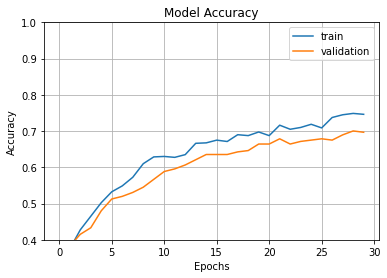

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 30
batch_size      : 8
learning rate   : 0.0001


The Best Training   Acc 0.7487499713897705
The Best Validation Acc 0.7003610134124756
Evaluate on test data.....................
33/33 [==============================] - 3s 32ms/step - loss: 0.8316 - accuracy: 0.7008
Test loss, Test acc: [0.8316054940223694, 0.7007575631141663]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 30
batch_size = 8
effective_lr = 0.0001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.SGD(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(49, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(16, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(19, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               1049088   
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/49 [==============================] - 13s 135ms/step - loss: 1.2397 - accuracy: 0.5378 - val_loss: 0.9666 - val_accuracy: 0.6246
Epoch 2/30
49/49 [==============================] - 3s 61ms/step - loss: 0.7613 - accuracy: 0.7362 - val_loss: 0.7781 - val_accuracy: 0.7276
Epoch 3/30
49/49 [==============================] - 3s 61ms/step - loss: 0.6101 - accuracy: 0.7900 - val_loss: 0.6956 - val_accuracy: 0.7375
Epoch 4/30
49/49 [==============================] - 3s 62ms/step - loss: 0.5072 - accuracy: 0.8310 - val_loss: 0.6458 - val_accuracy: 0.7475
Epoch 5/30
49/49 [==============================] - 3s 61ms/step - loss: 0.4745 - accuracy: 0.8259 - val_loss: 0.6223 - val_accuracy: 0.7608
Epoch 6/30
49/49 [==============================] - 3s 62ms/step - loss: 0.3769 - accuracy: 0.8899 - val_loss: 0.5736 - val_accuracy: 0.7874
Epoch 7/30
49/49 [==============================] - 3s 63ms/step - loss: 0.3884 - accuracy: 0.8758 - val_loss: 0.5588 - val_accuracy: 0.7874
Epoch 8/30
49/49 [====

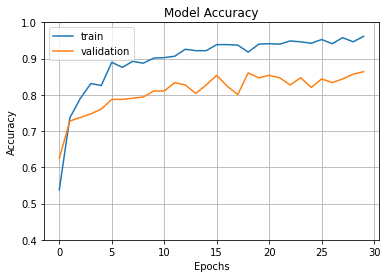

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 30
batch_size      : 16
learning rate   : 0.0001


The Best Training   Acc 0.9615877270698547
The Best Validation Acc 0.8637873530387878
Evaluate on test data.....................
16/16 [==============================] - 2s 47ms/step - loss: 0.2074 - accuracy: 0.9258
Test loss, Test acc: [0.20737867057323456, 0.92578125]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 30
batch_size = 16
effective_lr = 0.0001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(24, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(8, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(10, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               1049088   
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/24 [==============================] - 12s 258ms/step - loss: 1.5999 - accuracy: 0.3869 - val_loss: 1.1271 - val_accuracy: 0.5552
Epoch 2/30
24/24 [==============================] - 3s 113ms/step - loss: 0.9007 - accuracy: 0.6627 - val_loss: 0.9054 - val_accuracy: 0.6467
Epoch 3/30
24/24 [==============================] - 3s 112ms/step - loss: 0.7213 - accuracy: 0.7464 - val_loss: 0.8407 - val_accuracy: 0.6593
Epoch 4/30
24/24 [==============================] - 3s 113ms/step - loss: 0.6470 - accuracy: 0.7686 - val_loss: 0.7420 - val_accuracy: 0.7287
Epoch 5/30
24/24 [==============================] - 3s 115ms/step - loss: 0.5665 - accuracy: 0.8131 - val_loss: 0.6808 - val_accuracy: 0.7382
Epoch 6/30
24/24 [==============================] - 3s 113ms/step - loss: 0.4970 - accuracy: 0.8353 - val_loss: 0.6166 - val_accuracy: 0.7571
Epoch 7/30
24/24 [==============================] - 3s 115ms/step - loss: 0.4856 - accuracy: 0.8510 - val_loss: 0.5846 - val_accuracy: 0.8013
Epoch 8/30
24/24

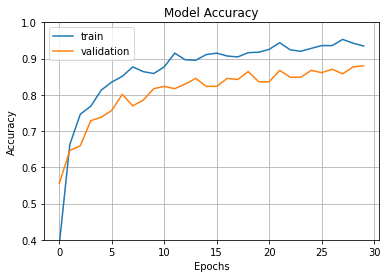

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 30
batch_size      : 32
learning rate   : 0.0001


The Best Training   Acc 0.9529411792755127
The Best Validation Acc 0.8801261782646179
Evaluate on test data.....................
8/8 [==============================] - 3s 85ms/step - loss: 0.2312 - accuracy: 0.9297
Test loss, Test acc: [0.2311897873878479, 0.9296875]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 30
batch_size = 32
effective_lr = 0.0001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(12, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(4, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(5, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_19 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               1049088   
                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - 14s 610ms/step - loss: 1.6292 - accuracy: 0.3307 - val_loss: 1.3086 - val_accuracy: 0.4637
Epoch 2/30
12/12 [==============================] - 3s 215ms/step - loss: 1.0785 - accuracy: 0.6068 - val_loss: 0.9872 - val_accuracy: 0.6341
Epoch 3/30
12/12 [==============================] - 3s 224ms/step - loss: 0.8819 - accuracy: 0.6810 - val_loss: 0.8467 - val_accuracy: 0.7035
Epoch 4/30
12/12 [==============================] - 3s 216ms/step - loss: 0.7232 - accuracy: 0.7435 - val_loss: 0.7539 - val_accuracy: 0.7445
Epoch 5/30
12/12 [==============================] - 3s 218ms/step - loss: 0.6615 - accuracy: 0.7747 - val_loss: 0.6662 - val_accuracy: 0.7950
Epoch 6/30
12/12 [==============================] - 3s 218ms/step - loss: 0.5703 - accuracy: 0.8125 - val_loss: 0.6054 - val_accuracy: 0.8139
Epoch 7/30
12/12 [==============================] - 3s 218ms/step - loss: 0.5108 - accuracy: 0.8255 - val_loss: 0.5666 - val_accuracy: 0.8202
Epoch 8/30
12/12

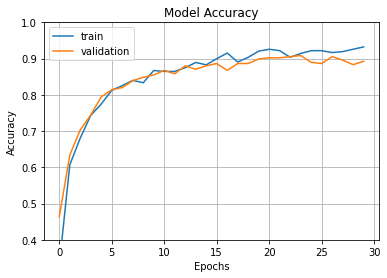

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 30
batch_size      : 64
learning rate   : 0.0001


The Best Training   Acc 0.9322916865348816
The Best Validation Acc 0.9085173606872559
Evaluate on test data.....................
4/4 [==============================] - 3s 153ms/step - loss: 0.3737 - accuracy: 0.8672
Test loss, Test acc: [0.37368249893188477, 0.8671875]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 30
batch_size = 64
effective_lr = 0.0001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               1049088   
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 13s 74ms/step - loss: 1.0750 - accuracy: 0.5875 - val_loss: 0.9148 - val_accuracy: 0.6606
Epoch 2/10
100/100 [==============================] - 4s 38ms/step - loss: 0.6666 - accuracy: 0.7700 - val_loss: 0.7021 - val_accuracy: 0.7437
Epoch 3/10
100/100 [==============================] - 4s 38ms/step - loss: 0.5455 - accuracy: 0.8037 - val_loss: 0.6087 - val_accuracy: 0.7653
Epoch 4/10
100/100 [==============================] - 4s 39ms/step - loss: 0.4983 - accuracy: 0.8338 - val_loss: 0.5936 - val_accuracy: 0.7509
Epoch 5/10
100/100 [==============================] - 4s 38ms/step - loss: 0.4078 - accuracy: 0.8650 - val_loss: 0.4878 - val_accuracy: 0.8123
Epoch 6/10
100/100 [==============================] - 4s 39ms/step - loss: 0.3938 - accuracy: 0.8687 - val_loss: 0.4748 - val_accuracy: 0.8231
Epoch 7/10
100/100 [==============================] - 4s 38ms/step - loss: 0.3501 - accuracy: 0.8838 - val_loss: 0.4546 - val_accuracy: 0.8375
Epoch 8/1

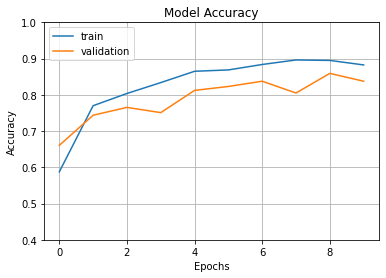

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 10
batch_size      : 8
learning rate   : 0.0001


The Best Training   Acc 0.8962500095367432
The Best Validation Acc 0.8592057824134827
Evaluate on test data.....................
33/33 [==============================] - 3s 31ms/step - loss: 0.4472 - accuracy: 0.8409
Test loss, Test acc: [0.44715794920921326, 0.8409090638160706]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 10
batch_size = 8
effective_lr = 0.0001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 512)               1049088   
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 13s 70ms/step - loss: 1.1043 - accuracy: 0.5825 - val_loss: 0.7748 - val_accuracy: 0.7437
Epoch 2/60
100/100 [==============================] - 4s 38ms/step - loss: 0.6793 - accuracy: 0.7613 - val_loss: 0.6256 - val_accuracy: 0.7906
Epoch 3/60
100/100 [==============================] - 4s 38ms/step - loss: 0.5292 - accuracy: 0.8250 - val_loss: 0.5839 - val_accuracy: 0.8051
Epoch 4/60
100/100 [==============================] - 4s 39ms/step - loss: 0.5079 - accuracy: 0.8275 - val_loss: 0.4913 - val_accuracy: 0.8339
Epoch 5/60
100/100 [==============================] - 4s 38ms/step - loss: 0.4210 - accuracy: 0.8413 - val_loss: 0.4528 - val_accuracy: 0.8520
Epoch 6/60
100/100 [==============================] - 4s 39ms/step - loss: 0.3832 - accuracy: 0.8763 - val_loss: 0.4458 - val_accuracy: 0.8556
Epoch 7/60
100/100 [==============================] - 4s 39ms/step - loss: 0.3375 - accuracy: 0.8875 - val_loss: 0.4313 - val_accuracy: 0.8484
Epoch 8/6

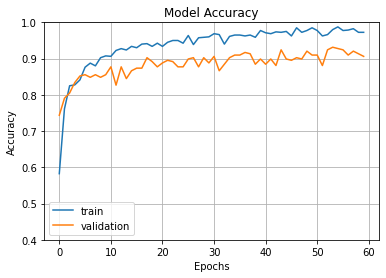

Ex. Hyper parameters :
layer_trainable : False
total_epochs    : 60
batch_size      : 8
learning rate   : 0.0001


The Best Training   Acc 0.987500011920929
The Best Validation Acc 0.9314079284667969
Evaluate on test data.....................
33/33 [==============================] - 3s 31ms/step - loss: 0.4529 - accuracy: 0.8788
Test loss, Test acc: [0.45285630226135254, 0.8787878751754761]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = False
total_epochs = 60
batch_size = 8
effective_lr = 0.0001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)


In [ ]:
##################################  EX1 End ###################################

Experiment 2

Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 512)               1049088   
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 23s 132ms/step - loss: 3.4011 - accuracy: 0.2547 - val_loss: 3404.9722 - val_accuracy: 0.2383
Epoch 2/30
100/100 [==============================] - 9s 94ms/step - loss: 1.5315 - accuracy: 0.3061 - val_loss: 116.9380 - val_accuracy: 0.2022
Epoch 3/30
100/100 [==============================] - 9s 94ms/step - loss: 1.4707 - accuracy: 0.3438 - val_loss: 1.4847 - val_accuracy: 0.3610
Epoch 4/30
100/100 [==============================] - 10s 95ms/step - loss: 1.4078 - accuracy: 0.3651 - val_loss: 3.6254 - val_accuracy: 0.3538
Epoch 5/30
100/100 [==============================] - 10s 96ms/step - loss: 1.3637 - accuracy: 0.3852 - val_loss: 1.3568 - val_accuracy: 0.4188
Epoch 6/30
100/100 [==============================] - 10s 97ms/step - loss: 1.3335 - accuracy: 0.4391 - val_loss: 1.2920 - val_accuracy: 0.4585
Epoch 7/30
100/100 [==============================] - 10s 97ms/step - loss: 1.2999 - accuracy: 0.4517 - val_loss: 1.4671 - val_accuracy: 0.4079

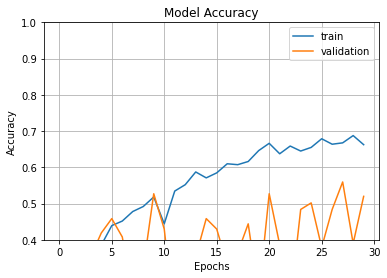

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 30
batch_size      : 8
learning rate   : 0.01


The Best Training   Acc 0.6875784397125244
The Best Validation Acc 0.5595667958259583
Evaluate on test data.....................
33/33 [==============================] - 3s 31ms/step - loss: 1.3275 - accuracy: 0.5455
Test loss, Test acc: [1.3275121450424194, 0.5454545617103577]


In [ ]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 30
batch_size = 8
effective_lr = 0.01
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)



Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               104908

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 186s 134ms/step - loss: 1.7137 - accuracy: 0.4454 - val_loss: 673.5420 - val_accuracy: 0.2419
Epoch 2/30
100/100 [==============================] - 9s 93ms/step - loss: 1.2731 - accuracy: 0.5006 - val_loss: 6.5156 - val_accuracy: 0.2491
Epoch 3/30
100/100 [==============================] - 10s 95ms/step - loss: 1.0874 - accuracy: 0.5734 - val_loss: 1.6186 - val_accuracy: 0.4188
Epoch 4/30
100/100 [==============================] - 9s 94ms/step - loss: 1.0191 - accuracy: 0.6286 - val_loss: 1.7901 - val_accuracy: 0.3357
Epoch 5/30
100/100 [==============================] - 9s 95ms/step - loss: 0.9207 - accuracy: 0.6524 - val_loss: 8.3456 - val_accuracy: 0.3357
Epoch 6/30
100/100 [==============================] - 10s 95ms/step - loss: 0.8745 - accuracy: 0.6763 - val_loss: 1.1228 - val_accuracy: 0.5884
Epoch 7/30
100/100 [==============================] - 10s 96ms/step - loss: 0.8599 - accuracy: 0.6775 - val_loss: 1.8930 - val_accuracy: 0.4296
Ep

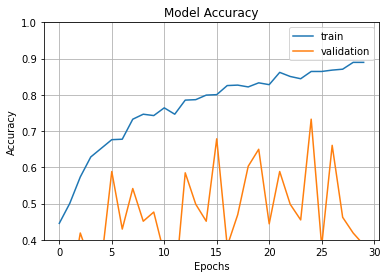

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 30
batch_size      : 8
learning rate   : 0.001


The Best Training   Acc 0.8895859718322754
The Best Validation Acc 0.7328519821166992
Evaluate on test data.....................
33/33 [==============================] - 3s 31ms/step - loss: 5.2535 - accuracy: 0.3447
Test loss, Test acc: [5.253548622131348, 0.344696968793869]


In [4]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 30
batch_size = 8
effective_lr = 0.001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)



Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 21s 126ms/step - loss: 0.9163 - accuracy: 0.6688 - val_loss: 1.4868 - val_accuracy: 0.6426
Epoch 2/30
100/100 [==============================] - 9s 95ms/step - loss: 0.4687 - accuracy: 0.8356 - val_loss: 0.7744 - val_accuracy: 0.8051
Epoch 3/30
100/100 [==============================] - 9s 95ms/step - loss: 0.3014 - accuracy: 0.8871 - val_loss: 0.6858 - val_accuracy: 0.8339
Epoch 4/30
100/100 [==============================] - 9s 95ms/step - loss: 0.2207 - accuracy: 0.9285 - val_loss: 0.5955 - val_accuracy: 0.8448
Epoch 5/30
100/100 [==============================] - 10s 96ms/step - loss: 0.1703 - accuracy: 0.9423 - val_loss: 0.4611 - val_accuracy: 0.8773
Epoch 6/30
100/100 [==============================] - 10s 96ms/step - loss: 0.2226 - accuracy: 0.9235 - val_loss: 1.5396 - val_accuracy: 0.7798
Epoch 7/30
100/100 [==============================] - 10s 97ms/step - loss: 0.1907 - accuracy: 0.9373 - val_loss: 1.7382 - val_accuracy: 0.7509
Epoch

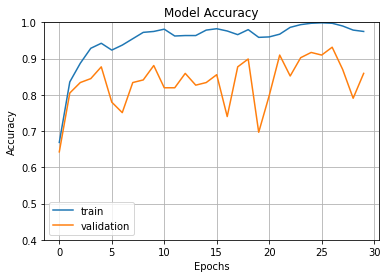

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 30
batch_size      : 8
learning rate   : 0.0001


The Best Training   Acc 0.998745322227478
The Best Validation Acc 0.9314079284667969
Evaluate on test data.....................
33/33 [==============================] - 3s 32ms/step - loss: 0.7355 - accuracy: 0.8598
Test loss, Test acc: [0.7354722023010254, 0.8598484992980957]


In [5]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 30
batch_size = 8
effective_lr = 0.0001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)



Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 20s 126ms/step - loss: 1.6118 - accuracy: 0.3300 - val_loss: 1.2960 - val_accuracy: 0.5090
Epoch 2/30
100/100 [==============================] - 10s 97ms/step - loss: 1.0512 - accuracy: 0.6313 - val_loss: 0.8922 - val_accuracy: 0.6823
Epoch 3/30
100/100 [==============================] - 10s 99ms/step - loss: 0.7859 - accuracy: 0.7625 - val_loss: 0.6944 - val_accuracy: 0.7617
Epoch 4/30
100/100 [==============================] - 10s 99ms/step - loss: 0.6107 - accuracy: 0.8050 - val_loss: 0.5779 - val_accuracy: 0.8087
Epoch 5/30
100/100 [==============================] - 10s 99ms/step - loss: 0.5028 - accuracy: 0.8400 - val_loss: 0.4888 - val_accuracy: 0.8339
Epoch 6/30
100/100 [==============================] - 10s 100ms/step - loss: 0.4267 - accuracy: 0.8687 - val_loss: 0.4317 - val_accuracy: 0.8520
Epoch 7/30
100/100 [==============================] - 10s 101ms/step - loss: 0.3594 - accuracy: 0.8875 - val_loss: 0.3913 - val_accuracy: 0.8628


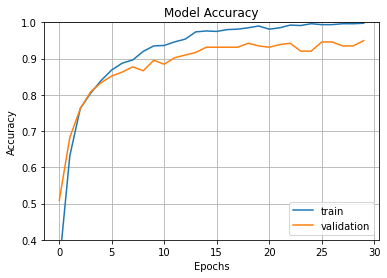

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 30
batch_size      : 8
learning rate   : 1e-05


The Best Training   Acc 0.9975000023841858
The Best Validation Acc 0.9494584798812866
Evaluate on test data.....................
33/33 [==============================] - 3s 32ms/step - loss: 0.1978 - accuracy: 0.9394
Test loss, Test acc: [0.19779926538467407, 0.939393937587738]


In [6]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 30
batch_size = 8
effective_lr = 0.00001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)



Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(100, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(33, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(35, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


100/100 [==============================] - 24s 128ms/step - loss: 2.0469 - accuracy: 0.1625 - val_loss: 2.2259 - val_accuracy: 0.1986
Epoch 2/30
100/100 [==============================] - 10s 98ms/step - loss: 2.0121 - accuracy: 0.1787 - val_loss: 2.1449 - val_accuracy: 0.2130
Epoch 3/30
100/100 [==============================] - 10s 97ms/step - loss: 1.9790 - accuracy: 0.1925 - val_loss: 2.1018 - val_accuracy: 0.2202
Epoch 4/30
100/100 [==============================] - 10s 96ms/step - loss: 1.9684 - accuracy: 0.1825 - val_loss: 2.0691 - val_accuracy: 0.2130
Epoch 5/30
100/100 [==============================] - 10s 96ms/step - loss: 1.9226 - accuracy: 0.1887 - val_loss: 2.0274 - val_accuracy: 0.2419
Epoch 6/30
100/100 [==============================] - 10s 96ms/step - loss: 1.9346 - accuracy: 0.1863 - val_loss: 2.0005 - val_accuracy: 0.2383
Epoch 7/30
100/100 [==============================] - 10s 95ms/step - loss: 1.8855 - accuracy: 0.2062 - val_loss: 1.9768 - val_accuracy: 0.2527
Ep

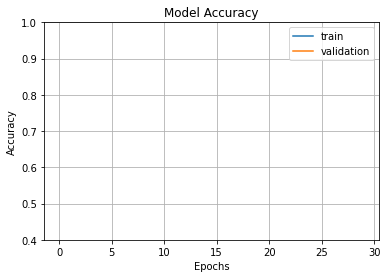

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 30
batch_size      : 8
learning rate   : 1e-05


The Best Training   Acc 0.36125001311302185
The Best Validation Acc 0.35740071535110474
Evaluate on test data.....................
33/33 [==============================] - 3s 33ms/step - loss: 1.5628 - accuracy: 0.3144
Test loss, Test acc: [1.5628046989440918, 0.31439393758773804]


In [7]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 30
batch_size = 8
effective_lr = 0.00001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.SGD(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)



Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(49, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(16, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(19, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/49 [==============================] - 21s 229ms/step - loss: 1.7312 - accuracy: 0.3151 - val_loss: 1.6002 - val_accuracy: 0.3854
Epoch 2/30
49/49 [==============================] - 8s 156ms/step - loss: 1.1751 - accuracy: 0.5969 - val_loss: 1.1352 - val_accuracy: 0.6080
Epoch 3/30
49/49 [==============================] - 8s 158ms/step - loss: 0.8959 - accuracy: 0.7385 - val_loss: 0.8391 - val_accuracy: 0.7176
Epoch 4/30
49/49 [==============================] - 8s 158ms/step - loss: 0.7004 - accuracy: 0.8048 - val_loss: 0.6535 - val_accuracy: 0.8007
Epoch 5/30
49/49 [==============================] - 8s 159ms/step - loss: 0.5764 - accuracy: 0.8342 - val_loss: 0.5309 - val_accuracy: 0.8439
Epoch 6/30
49/49 [==============================] - 8s 160ms/step - loss: 0.4771 - accuracy: 0.8661 - val_loss: 0.4526 - val_accuracy: 0.8472
Epoch 7/30
49/49 [==============================] - 8s 160ms/step - loss: 0.4067 - accuracy: 0.8916 - val_loss: 0.3934 - val_accuracy: 0.8870
Epoch 8/30
49/49

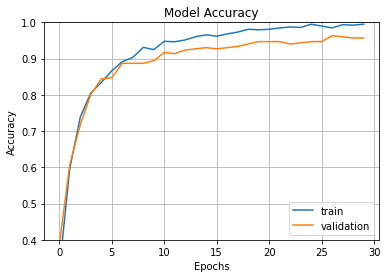

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 30
batch_size      : 16
learning rate   : 1e-05


The Best Training   Acc 0.9948979616165161
The Best Validation Acc 0.9634551405906677
Evaluate on test data.....................
16/16 [==============================] - 2s 48ms/step - loss: 0.0961 - accuracy: 0.9688
Test loss, Test acc: [0.09614559262990952, 0.96875]


In [8]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 30
batch_size = 16
effective_lr = 0.00001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)



Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(24, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(8, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(10, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/24 [==============================] - 23s 489ms/step - loss: 1.6944 - accuracy: 0.2928 - val_loss: 1.4045 - val_accuracy: 0.4574
Epoch 2/30
24/24 [==============================] - 7s 281ms/step - loss: 1.2827 - accuracy: 0.5203 - val_loss: 1.1685 - val_accuracy: 0.5804
Epoch 3/30
24/24 [==============================] - 7s 283ms/step - loss: 1.0216 - accuracy: 0.6680 - val_loss: 0.9849 - val_accuracy: 0.6845
Epoch 4/30
24/24 [==============================] - 7s 284ms/step - loss: 0.8795 - accuracy: 0.7137 - val_loss: 0.8287 - val_accuracy: 0.7192
Epoch 5/30
24/24 [==============================] - 7s 285ms/step - loss: 0.7206 - accuracy: 0.7804 - val_loss: 0.6984 - val_accuracy: 0.7666
Epoch 6/30
24/24 [==============================] - 7s 286ms/step - loss: 0.6149 - accuracy: 0.8261 - val_loss: 0.5947 - val_accuracy: 0.8170
Epoch 7/30
24/24 [==============================] - 7s 288ms/step - loss: 0.5446 - accuracy: 0.8248 - val_loss: 0.5213 - val_accuracy: 0.8423
Epoch 8/30
24/24

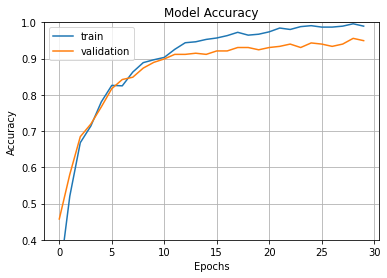

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 30
batch_size      : 32
learning rate   : 1e-05


The Best Training   Acc 0.9960784316062927
The Best Validation Acc 0.9558359384536743
Evaluate on test data.....................
8/8 [==============================] - 3s 82ms/step - loss: 0.1515 - accuracy: 0.9570
Test loss, Test acc: [0.15146377682685852, 0.95703125]


In [9]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 30
batch_size = 32
effective_lr = 0.00001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)



Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(12, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(4, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(5, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - 25s 940ms/step - loss: 1.9275 - accuracy: 0.2305 - val_loss: 1.6234 - val_accuracy: 0.3533
Epoch 2/30
12/12 [==============================] - 7s 550ms/step - loss: 1.5036 - accuracy: 0.3971 - val_loss: 1.4596 - val_accuracy: 0.4322
Epoch 3/30
12/12 [==============================] - 7s 553ms/step - loss: 1.2601 - accuracy: 0.5534 - val_loss: 1.3486 - val_accuracy: 0.4858
Epoch 4/30
12/12 [==============================] - 7s 555ms/step - loss: 1.0724 - accuracy: 0.6497 - val_loss: 1.2188 - val_accuracy: 0.5174
Epoch 5/30
12/12 [==============================] - 7s 548ms/step - loss: 0.9841 - accuracy: 0.6810 - val_loss: 1.0870 - val_accuracy: 0.5773
Epoch 6/30
12/12 [==============================] - 6s 540ms/step - loss: 0.8711 - accuracy: 0.7253 - val_loss: 0.9758 - val_accuracy: 0.6467
Epoch 7/30
12/12 [==============================] - 6s 539ms/step - loss: 0.7550 - accuracy: 0.7734 - val_loss: 0.8759 - val_accuracy: 0.6751
Epoch 8/30
12/12

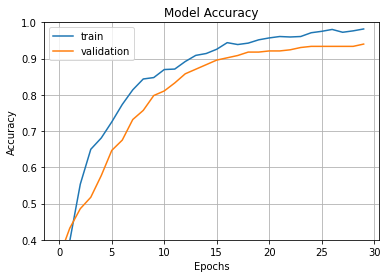

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 30
batch_size      : 64
learning rate   : 1e-05


The Best Training   Acc 0.9817708134651184
The Best Validation Acc 0.9400631189346313
Evaluate on test data.....................
4/4 [==============================] - 3s 153ms/step - loss: 0.2543 - accuracy: 0.9141
Test loss, Test acc: [0.2542932331562042, 0.9140625]


In [10]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 30
batch_size = 64
effective_lr = 0.00001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)



Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(49, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(16, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(19, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               1049088   
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/49 [==============================] - 23s 256ms/step - loss: 1.4947 - accuracy: 0.4213 - val_loss: 1.4222 - val_accuracy: 0.4153
Epoch 2/10
49/49 [==============================] - 8s 157ms/step - loss: 1.0743 - accuracy: 0.6376 - val_loss: 0.9861 - val_accuracy: 0.6246
Epoch 3/10
49/49 [==============================] - 8s 158ms/step - loss: 0.8270 - accuracy: 0.7490 - val_loss: 0.7417 - val_accuracy: 0.7375
Epoch 4/10
49/49 [==============================] - 8s 158ms/step - loss: 0.6752 - accuracy: 0.7939 - val_loss: 0.5971 - val_accuracy: 0.8073
Epoch 5/10
49/49 [==============================] - 8s 159ms/step - loss: 0.5506 - accuracy: 0.8374 - val_loss: 0.4926 - val_accuracy: 0.8405
Epoch 6/10
49/49 [==============================] - 8s 160ms/step - loss: 0.4377 - accuracy: 0.8886 - val_loss: 0.4267 - val_accuracy: 0.8538
Epoch 7/10
49/49 [==============================] - 8s 160ms/step - loss: 0.3845 - accuracy: 0.8899 - val_loss: 0.3840 - val_accuracy: 0.8704
Epoch 8/10
49/49

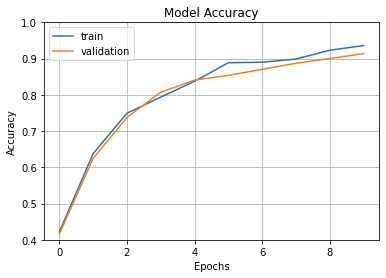

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 10
batch_size      : 16
learning rate   : 1e-05


The Best Training   Acc 0.9359794855117798
The Best Validation Acc 0.9136212468147278
Evaluate on test data.....................
16/16 [==============================] - 2s 50ms/step - loss: 0.2536 - accuracy: 0.9141
Test loss, Test acc: [0.25361114740371704, 0.9140625]


In [11]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 10
batch_size = 16
effective_lr = 0.00001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)



Found 1341 files belonging to 6 classes.
1341
Batches for training --> tf.Tensor(49, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(16, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(19, shape=(), dtype=int64)
['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               1049088   
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/49 [==============================] - 21s 220ms/step - loss: 1.7027 - accuracy: 0.3278 - val_loss: 1.4772 - val_accuracy: 0.3887
Epoch 2/60
49/49 [==============================] - 8s 159ms/step - loss: 1.1686 - accuracy: 0.5928 - val_loss: 1.0526 - val_accuracy: 0.6113
Epoch 3/60
49/49 [==============================] - 8s 158ms/step - loss: 0.9116 - accuracy: 0.7042 - val_loss: 0.8106 - val_accuracy: 0.7143
Epoch 4/60
49/49 [==============================] - 8s 158ms/step - loss: 0.7196 - accuracy: 0.7798 - val_loss: 0.6474 - val_accuracy: 0.7807
Epoch 5/60
49/49 [==============================] - 8s 160ms/step - loss: 0.5963 - accuracy: 0.8297 - val_loss: 0.5453 - val_accuracy: 0.8106
Epoch 6/60
49/49 [==============================] - 8s 160ms/step - loss: 0.4892 - accuracy: 0.8630 - val_loss: 0.4644 - val_accuracy: 0.8538
Epoch 7/60
49/49 [==============================] - 8s 161ms/step - loss: 0.4242 - accuracy: 0.8784 - val_loss: 0.3994 - val_accuracy: 0.8804
Epoch 8/60
49/49

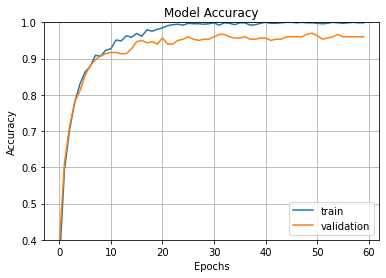

Ex. Hyper parameters :
layer_trainable : True
total_epochs    : 60
batch_size      : 16
learning rate   : 1e-05


The Best Training   Acc 1.0
The Best Validation Acc 0.970099687576294
Evaluate on test data.....................
16/16 [==============================] - 2s 48ms/step - loss: 0.2250 - accuracy: 0.9414
Test loss, Test acc: [0.22497279942035675, 0.94140625]


In [12]:
##########################################################
#Hyper Parameters ###                Exp1 ResNet50-Frozen
num_classes = 6
img_height = 224
img_width = 224


layer_trainable = True
total_epochs = 60
batch_size = 16
effective_lr = 0.00001
##########################################################
full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

DATASET_SIZE = len(list(full_dataset.file_paths))
print (DATASET_SIZE)



train_size = int(0.6 * int(DATASET_SIZE/batch_size))
val_size = int(0.2 * int(DATASET_SIZE/batch_size))
test_size = int(0.2 * int(DATASET_SIZE/batch_size))

shuffle_full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = shuffle_full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print('Batches for training -->'  , train_dataset.cardinality())
print('Batches for testing -->'   , test_dataset.cardinality())
print('Batches for validating -->', val_dataset.cardinality())


class_names = full_dataset.class_names
print(class_names)

#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 10))
#for images, labels in full_dataset.take(1):
#    for i in range(3):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
#normalization_layer = tf.keras.layers.Rescaling(1./255)

#normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




from tensorflow.keras import layers, models

resnet_model = models.Sequential([])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

drop_layer = tf.keras.layers.Dropout(.8, )

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=layer_trainable

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
###resnet_model.add(drop_layer)
resnet_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

resnet_model.build( input_shape=(None,224,224,3))
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=effective_lr),loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history = resnet_model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs)



fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


best_t_score = max(history.history['accuracy'])
best_v_score = max(history.history['val_accuracy'])


print ('=====================================')
print ('Ex. Hyper parameters :')
print ('layer_trainable :' , layer_trainable)
print ('total_epochs    :' , total_epochs)
print ('batch_size      :',  batch_size)
print ('learning rate   :', effective_lr)

print ('')
print ('')
print ('The Best Training   Acc', best_t_score)
print ('The Best Validation Acc', best_v_score)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data.....................")
results = resnet_model.evaluate(test_dataset, batch_size=32)
print("Test loss, Test acc:", results)

